In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from load_data_and_distribution_analisys import load_dataset_cleaned, plot_confusion_matrix, split_dataset_v1

# Stacking Classifier e Voting Classifier

In questo notebook viene riportato l'utilizzo di un altra tecnica di ensemble learning: lo stacking. A differenza di metodi come il bagging e il boosting, che combinano le predizioni di più modelli, lo stacking utilizza un approccio più sofisticato in cui diversi modelli base vengono allenati in parallelo e successivamente le loro predizioni vengono utilizzate come input per un nuovo modello finale, il quale ha il compito di combinare in modo ottimale le informazioni provenienti dai modelli di base, cercando di correggere gli errori di ciascun classificatore e migliorare la capacità predittiva.  Abbiamo scelto di testare lo stacking perché pensiamo possa sfruttare i punti di forza di modelli diversi, combinandoli in modo strategico per ottenere una maggiore robustezza e generalizzazione; abbiamo selezionato come modelli base quelli utilizzati fino ad ora nel progetto, ovvero Random Forest, AdaBoost e KNN, come meta-modello invece Support Vector Machine lineare.

Oltre alla tecnica dello stacking, in questo notebook viene anche testato un ulteriore metodo di ensemble learning: il Voting Classifier. A differenza dello stacking, in cui le predizioni dei modelli base vengono utilizzate come input per un modello finale, il Voting Classifier combina direttamente le predizioni dei modelli base tramite una regola di aggregazione: 
- Hard voting, in cui viene scelta la classe più votata tra i modelli base.
- Soft voting (quella scelta da noi), in cui si calcola la media delle probabilità di appartenenza alle classi e si assegna la classe con probabilità maggiore.

In [6]:
dataset = load_dataset_cleaned()

Path to dataset files: /Users/marcodeano/.cache/kagglehub/datasets/sooyoungher/smoking-drinking-dataset/versions/2
   sex  age  height  weight  waistline  sight_left  sight_right  hear_left  \
0    1   35     170      75       90.0         1.0          1.0        1.0   
1    1   30     180      80       89.0         0.9          1.2        1.0   
2    1   40     165      75       91.0         1.2          1.5        1.0   
3    1   50     175      80       91.0         1.5          1.2        1.0   
4    1   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP  ...  LDL_chole  triglyceride  hemoglobin  urine_protein  \
0         1.0  120.0  ...      126.0          92.0        17.1            1.0   
1         1.0  130.0  ...      148.0         121.0        15.8            1.0   
2         1.0  120.0  ...       74.0         104.0        15.8            1.0   
3         1.0  145.0  ...      104.0         106.0        17.6            1.0   
4         1

In [7]:
X_smoke, y_smoke, X_drink, y_drink = split_dataset_v1(dataset)

## Smoking

In [8]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smoke, y_smoke, test_size=0.2, random_state=42, stratify=y_smoke)

In [9]:
model = {
    "knn": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=500, n_jobs=-1))]),
    "rf": Pipeline([("random_forest", RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=50, random_state=42, class_weight='balanced', n_jobs=-1))]),
    "adaboost": Pipeline([("scaler", StandardScaler()), ("adaboost", AdaBoostClassifier(n_estimators=100, random_state=42))])
}

In [10]:
estimators = [
    ('rf', model["rf"]),
    ('knn', model["knn"]),
    ('adaboost', model["adaboost"])
]

stacking = StackingClassifier(estimators=estimators, final_estimator=LinearSVC(), n_jobs=-1, cv=2)

In [11]:
stacking.fit(X_train_s, y_train_s)

/Users/marcodeano/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/marcodeano/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/marcodeano/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=2,
                   estimators=[('rf',
                                Pipeline(steps=[('random_forest',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        max_depth=50,
                                                                        min_samples_split=50,
                                                                        n_jobs=-1,
                                                                        random_state=42))])),
                               ('knn',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('knn',
                                                 KNeighborsClassifier(n_jobs=-1,
                                                                      n_neighbors=500))])),
                               ('adaboost',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('adaboost',
                                                 AdaBoostClassifier(n_estimators=100,
                                                                    random_state=42))]))],
                   final_estimator=LinearSVC(), n_jobs=-1)

              precision    recall  f1-score   support

         1.0       0.89      0.79      0.83    111686
         2.0       0.44      0.44      0.44     31585
         3.0       0.50      0.66      0.57     39049

    accuracy                           0.70    182320
   macro avg       0.61      0.63      0.61    182320
weighted avg       0.73      0.70      0.71    182320



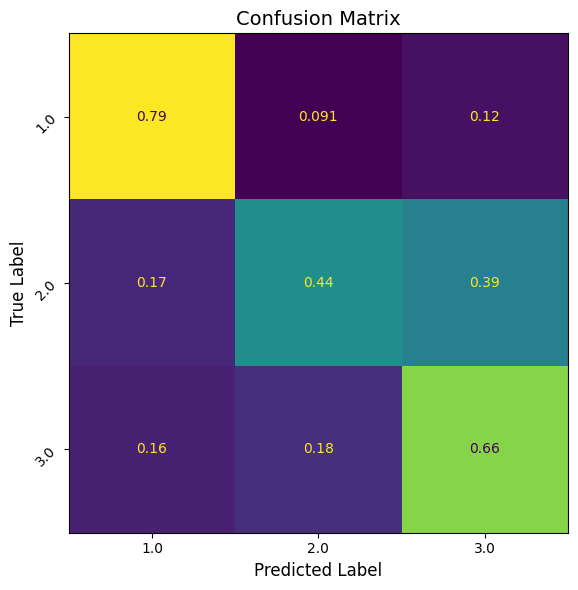

In [12]:
y_pred_s = stacking.predict(X_test_s)

report = classification_report(y_test_s, y_pred_s)
print(report)
plot_confusion_matrix(y_test_s, y_pred_s, stacking.classes_, "Confusion Matrix", cmap='viridis')

In [13]:
estimators = [
    #("svc", Pipeline([("scaler", StandardScaler()), ("svc", LinearSVC(random_state=42))])),
    ("knn", Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=500, n_jobs=-1))])),
    ("rf", Pipeline([("random_forest", RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=50, random_state=42, class_weight='balanced', n_jobs=-1))])),
    ("adaboost", Pipeline([("scaler", StandardScaler()), ("adaboost", AdaBoostClassifier(n_estimators=100, random_state=42))]))
]

voting = VotingClassifier(estimators=estimators, n_jobs=-1, voting='soft')

In [14]:
voting.fit(X_train_s, y_train_s)

/Users/marcodeano/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


VotingClassifier(estimators=[('knn',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier(n_jobs=-1,
                                                                    n_neighbors=500))])),
                             ('rf',
                              Pipeline(steps=[('random_forest',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_depth=50,
                                                                      min_samples_split=50,
                                                                      n_jobs=-1,
                                                                      random_state=42))])),
                             ('adaboost',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('adaboost',
                                               AdaBoostClassifier(n_estimators=100,
                                                                  random_state=42))]))],
                 n_jobs=-1, voting='soft')

              precision    recall  f1-score   support

         1.0       0.93      0.74      0.83    111686
         2.0       0.43      0.53      0.47     31585
         3.0       0.48      0.66      0.56     39049

    accuracy                           0.69    182320
   macro avg       0.61      0.65      0.62    182320
weighted avg       0.75      0.69      0.71    182320



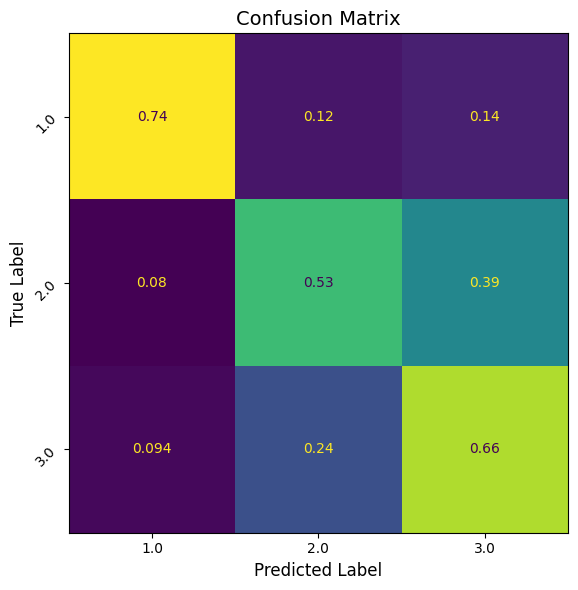

In [15]:
y_pred_s = voting.predict(X_test_s)

report = classification_report(y_test_s, y_pred_s)
print(report)
plot_confusion_matrix(y_test_s, y_pred_s, voting.classes_, "Confusion Matrix", cmap='viridis')

## Drinking

In [16]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_drink, y_drink, test_size=0.2, random_state=42, stratify=y_drink)

In [17]:
model = {
    "knn": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=500, n_jobs=-1))]),
    "rf": Pipeline([("random_forest", RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=50, random_state=42, class_weight='balanced', n_jobs=-1))]),
    "adaboost": Pipeline([("scaler", StandardScaler()), ("adaboost", AdaBoostClassifier(n_estimators=100, random_state=42))])
}

In [18]:
estimators = [
    ('rf', model["rf"]),
    ('knn', model["knn"]),
    ('adaboost', model["adaboost"])
]

stacking = StackingClassifier(estimators=estimators, final_estimator=LinearSVC(), n_jobs=-1, cv=2)

In [19]:
stacking.fit(X_train_d, y_train_d)

/Users/marcodeano/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/marcodeano/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/marcodeano/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=2,
                   estimators=[('rf',
                                Pipeline(steps=[('random_forest',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        max_depth=50,
                                                                        min_samples_split=50,
                                                                        n_jobs=-1,
                                                                        random_state=42))])),
                               ('knn',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('knn',
                                                 KNeighborsClassifier(n_jobs=-1,
                                                                      n_neighbors=500))])),
                               ('adaboost',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('adaboost',
                                                 AdaBoostClassifier(n_estimators=100,
                                                                    random_state=42))]))],
                   final_estimator=LinearSVC(), n_jobs=-1)

              precision    recall  f1-score   support

           0       0.73      0.71      0.72     90360
           1       0.72      0.74      0.73     91960

    accuracy                           0.73    182320
   macro avg       0.73      0.73      0.73    182320
weighted avg       0.73      0.73      0.73    182320



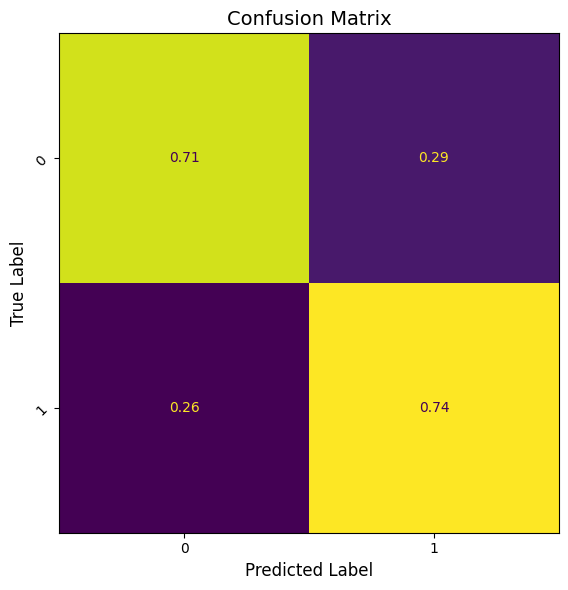

In [20]:
y_pred_d = stacking.predict(X_test_d)

report = classification_report(y_test_d, y_pred_d)
print(report)
plot_confusion_matrix(y_test_d, y_pred_d, stacking.classes_, "Confusion Matrix", cmap='viridis')

In [21]:
estimators = [
    #("svc", Pipeline([("scaler", StandardScaler()), ("svc", LinearSVC(random_state=42))])),
    ("knn", Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=500, n_jobs=-1))])),
    ("rf", Pipeline([("random_forest", RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=50, random_state=42, class_weight='balanced', n_jobs=-1))])),
    ("adaboost", Pipeline([("scaler", StandardScaler()), ("adaboost", AdaBoostClassifier(n_estimators=100, random_state=42))]))
]

voting = VotingClassifier(estimators=estimators, n_jobs=-1, voting='soft')

In [22]:
voting.fit(X_train_d, y_train_d)

/Users/marcodeano/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


VotingClassifier(estimators=[('knn',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier(n_jobs=-1,
                                                                    n_neighbors=500))])),
                             ('rf',
                              Pipeline(steps=[('random_forest',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_depth=50,
                                                                      min_samples_split=50,
                                                                      n_jobs=-1,
                                                                      random_state=42))])),
                             ('adaboost',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('adaboost',
                                               AdaBoostClassifier(n_estimators=100,
                                                                  random_state=42))]))],
                 n_jobs=-1, voting='soft')

              precision    recall  f1-score   support

           0       0.74      0.68      0.71     90360
           1       0.71      0.76      0.73     91960

    accuracy                           0.72    182320
   macro avg       0.72      0.72      0.72    182320
weighted avg       0.72      0.72      0.72    182320



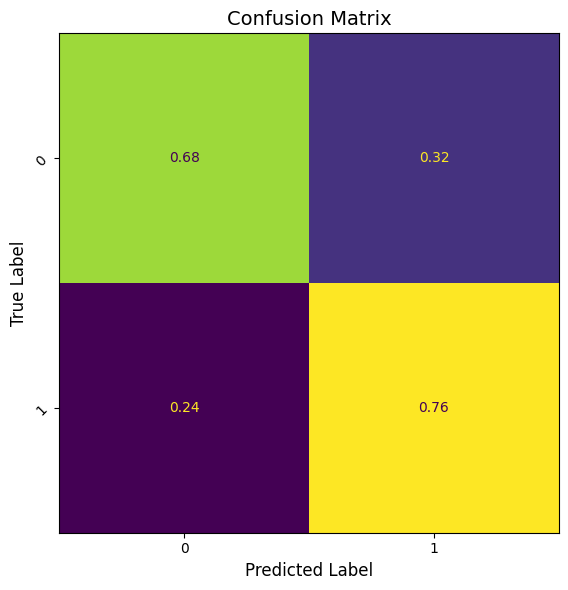

In [23]:
y_pred_d = voting.predict(X_test_d)

report = classification_report(y_test_d, y_pred_d)
print(report)
plot_confusion_matrix(y_test_d, y_pred_d, voting.classes_, "Confusion Matrix", cmap='viridis')